In [5]:
from pomegranate import *
import pandas as pd
import json
import os
import sys

org_df = pd.read_excel('organizational_df.xlsx')
path_to_bedgraphs = 'LB1/bedgraphs'
path_to_trained_hmms = 'HMM_outputs/LADs'

In [2]:
def parse_bedgraph(f, binsize, blacklistbed):
    # parses bedgraph file

    canonical_chroms = [ 'chr' + str(x) for x in range(1,23) ] + ['chrY', 'chrX']
    
    indf_pre = pd.read_csv(f, sep='\t', low_memory=False, header=None, 
        names=['chrom','start','stop','score']).dropna().query('chrom in @canonical_chroms')
    indf_pre['id'] = indf_pre.index
    
    inbed = BedTool.from_dataframe(indf_pre[['chrom','start','stop','id','score']]).sort()
    inbed_filt = inbed.subtract(blacklistbed).sort()#.intersect(umap_bed).sort()
    
    indf = inbed_filt.to_dataframe()
    indf.columns = ['chrom','start','stop','id','score']
    indf = indf[['chrom','start','stop','score']].copy()

    indf['size'] = indf['stop'] - indf['start']

    indf_split = indf.query('size > @binsize').copy()
    if len(indf_split) > 0:
        to_add = []
        for ix, row in indf_split.iterrows():
            n_intervals = row['size'] / binsize
            start = row['start']
            chrom = row['chrom']
            score = row[f'score']
            for val in range(int(n_intervals)):
                to_add.append(pd.DataFrame({
                    'chrom':[row['chrom']],
                    'start':[start],
                    'stop':[start + binsize],
                    'score':[score]
                }))
                start = start + binsize

        indf = pd.concat([indf.query('size == @binsize')[['chrom','start','stop',f'score']],
                          pd.concat(to_add)]).query('chrom in @canonical_chroms')
    else:
        indf = indf.query('size == @binsize')[['chrom','start','stop',f'score']].query('chrom in @canonical_chroms')
    return(indf)

# AIC and BIC per state number

In [1]:
# train_ctspecific_HMMs.py

from pomegranate import *
import pandas as pd
import json
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

org_df = pd.read_excel('organizational_df.xlsx')
path_to_bedgraphs = '/pollard/data/projects/upenn/analysis_files/chip_signal/qnormed_dat/LB1/bedgraphs'
path_to_trained_hmms = '/pollard/home/kathleen/projects/LADs/LAD_atlas/HMM_outputs/LADs'

In [2]:
states_dict = {
            2:['nonLAD','LAD'],
            3:['nonLAD','T2-LAD','T1-LAD'],
            4:['nonLAD','T3-LAD','T2-LAD','T1-LAD'],
            5:['nonLAD','T4-LAD','T3-LAD','T2-LAD','T1-LAD']
        }

def AIC(L, n_states):
    n_params = 2 # because normal distribution defined by mean and standard deviation
    return(2*(n_states**2 + n_params*n_states - 1) - 2*(L))

def BIC(L, n_states, n_obs):
    n_params = 2 # because normal distribution defined by mean and standard deviation
    return((n_params*n_states + n_states**2 - 1)*np.log(n_obs) - 2*L)

bics = []
n_states_list = []
aics = []
cts = []

for ix, row in org_df.query('chip == "LB1"').iterrows():
    for n_states in [2, 3, 4, 5]:
        ct = row['cell_type']
        with open(f'{path_to_trained_hmms}/hmms_{n_states}states/{ct}.json') as json_file:
                    dat_model = HiddenMarkovModel.from_json(json.load(json_file))
        
        dat = pd.read_table(f'{path_to_trained_hmms}/hmm_calls_{n_states}states/{ct}.tsv', names=['chrom','start','stop','score0','score1','hmm_pred'],
                           header=0)

        bic = BIC(dat_model.log_probability(dat[['score0','score1']].to_numpy()), n_states, len(dat))

        bics.append(bic)

        aic = AIC(dat_model.log_probability(dat[['score0','score1']].to_numpy()), n_states)

        aics.append(aic)

        n_states_list.append(n_states)

        cts.append(ct)

In [12]:
tog = pd.DataFrame({
    'ct':cts,
    'aic':aics,
    'bic':bics,
    'n_states':n_states_list
}).drop_duplicates()

aic_diffs = []
bic_diffs = []
states = []
cts = []

for state in [2,3,4]:
    for ct in tog['ct'].unique():
        cts.append(ct)
        s_plus_one = state + 1
        states.append(f'{state}->{s_plus_one}')
        aic_diffs.append(tog.query('ct == @ct and n_states == @state')['aic'].tolist()[0]-tog.query('ct == @ct and n_states == @s_plus_one')['aic'].tolist()[0])
        bic_diffs.append(tog.query('ct == @ct and n_states == @state')['bic'].tolist()[0]-tog.query('ct == @ct and n_states == @s_plus_one')['bic'].tolist()[0])
        
        

df = pd.DataFrame({
    'AIC_diff':aic_diffs,
    'BIC_diff':bic_diffs,
    'states':states,
    'ct':cts
})

Text(0.5, 0, 'cell type')

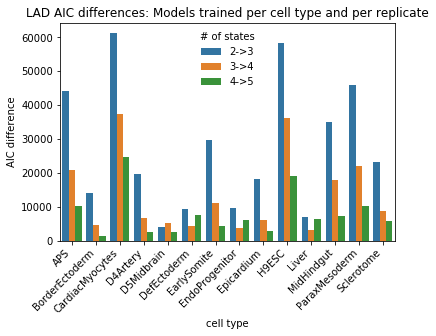

In [14]:
sns.barplot(x='ct', y='AIC_diff', hue='states', data=df,
           order=sorted(df['ct'].drop_duplicates()))
plt.xticks(rotation=45, ha='right')
plt.title('LAD AIC differences: Models trained per cell type and per replicate')
plt.legend(title='# of states', ncol=1, frameon=False)
plt.ylabel('AIC difference')
plt.xlabel('cell type')

Text(0.5, 0, 'cell type')

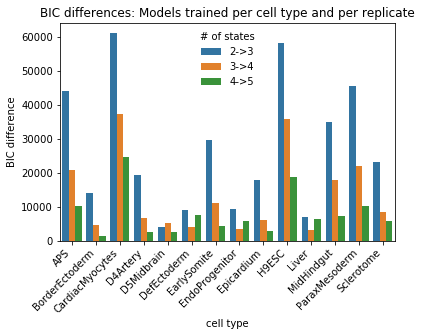

In [15]:
sns.barplot(x='ct', y='BIC_diff', hue='states', data=df,
           order=sorted(df['ct'].drop_duplicates()))
plt.xticks(rotation=45, ha='right')
plt.title('BIC differences: Models trained per cell type and per replicate')
plt.legend(title='# of states', ncol=1, frameon=False)
plt.ylabel('BIC difference')
plt.xlabel('cell type')

Text(0, 0.5, 'AIC')

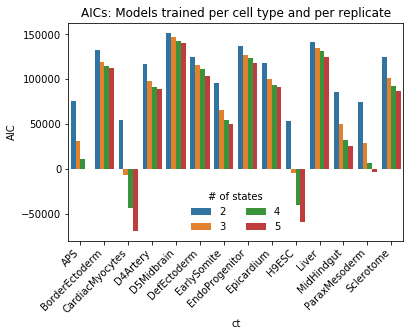

In [31]:
sns.barplot(x='ct', y='aic', hue='n_states', data=tog,
           order=sorted(df['ct'].drop_duplicates()))
plt.xticks(rotation=45, ha='right')
plt.title('AICs: Models trained per cell type and per replicate')
plt.legend(title='# of states', ncol=2, frameon=False)
plt.ylabel('AIC')

Text(0.5, 0, 'Cell type')

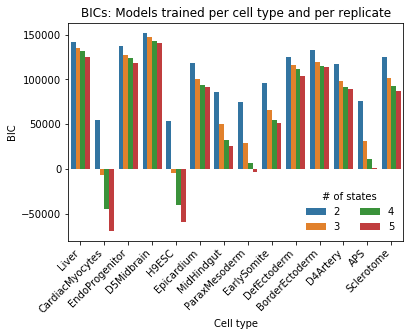

In [8]:
sns.barplot(x='ct', y='bic', hue='n_states', data=tog, ci='sd')
plt.xticks(rotation=45, ha='right')
plt.title('BICs: Models trained per cell type and per replicate')
plt.legend(title='# of states', ncol=2, frameon=False)
plt.ylabel('BIC')
plt.xlabel('Cell type')

# BIC diff plot for KDDs

In [3]:
path_to_bedgraphs = 'H3K9me2/bedgraphs'
path_to_trained_hmms = 'HMM_outputs/KDDs'

In [4]:
states_dict = {
            2:['nonKDD','KDD'],
            3:['nonKDD','T2-KDD','T1-KDD'],
            4:['nonKDD','T3-KDD','T2-KDD','T1-KDD'],
            5:['nonKDD','T4-KDD','T3-KDD','T2-KDD','T1-KDD']
        }

def AIC(L, n_states):
    n_params = 2 # because normal distribution defined by mean and standard deviation
    return(2*(n_states**2 + n_params*n_states - 1) - 2*(L))

def BIC(L, n_states, n_obs):
    n_params = 2 # because normal distribution defined by mean and standard deviation
    return((n_params*n_states + n_states**2 - 1)*np.log(n_obs) - 2*L)

bics = []
n_states_list = []
aics = []
cts = []

for ix, row in org_df.query('chip == "H3K9me2"').iterrows():
    for n_states in [2, 3, 4, 5]:
        ct = row['cell_type']
        with open(f'{path_to_trained_hmms}/hmms_{n_states}states/{ct}.json') as json_file:
                    dat_model = HiddenMarkovModel.from_json(json.load(json_file))
        
        dat = pd.read_table(f'{path_to_trained_hmms}/hmm_calls_{n_states}states/{ct}.tsv', names=['chrom','start','stop','score0','score1','hmm_pred'],
                           header=0)

        bic = BIC(dat_model.log_probability(dat[['score0','score1']].to_numpy()), n_states, len(dat))

        bics.append(bic)

        aic = AIC(dat_model.log_probability(dat[['score0','score1']].to_numpy()), n_states)

        aics.append(aic)

        n_states_list.append(n_states)

        cts.append(ct)

In [33]:
tog = pd.DataFrame({
    'ct':cts,
    'aic':aics,
    'bic':bics,
    'n_states':n_states_list
}).drop_duplicates()

aic_diffs = []
bic_diffs = []
states = []
cts = []

for state in [2,3,4]:
    for ct in tog['ct'].unique():
        cts.append(ct)
        s_plus_one = state + 1
        states.append(f'{state}->{s_plus_one}')
        aic_diffs.append(tog.query('ct == @ct and n_states == @state')['aic'].tolist()[0]-tog.query('ct == @ct and n_states == @s_plus_one')['aic'].tolist()[0])
        bic_diffs.append(tog.query('ct == @ct and n_states == @state')['bic'].tolist()[0]-tog.query('ct == @ct and n_states == @s_plus_one')['bic'].tolist()[0])
        
        

df = pd.DataFrame({
    'AIC_diff':aic_diffs,
    'BIC_diff':bic_diffs,
    'states':states,
    'ct':cts
})

Text(0.5, 0, 'cell type')

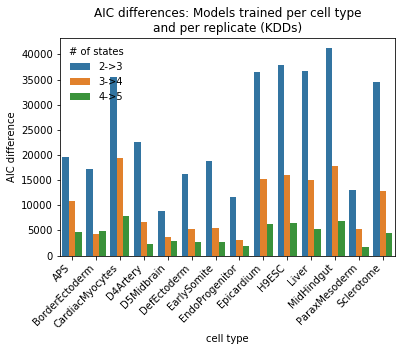

In [34]:
sns.barplot(x='ct', y='AIC_diff', hue='states', data=df,
           order=sorted(df['ct'].drop_duplicates()))
plt.xticks(rotation=45, ha='right')
plt.title('AIC differences: Models trained per cell type\nand per replicate (KDDs)')
plt.legend(title='# of states', ncol=1, frameon=False)
plt.ylabel('AIC difference')
plt.xlabel('cell type')

Text(0.5, 0, 'Cell type')

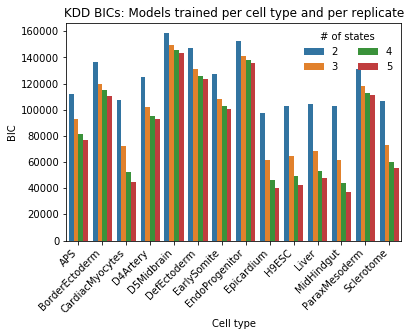

In [25]:
sns.barplot(x='ct', y='bic', hue='n_states', data=tog, ci='sd',
           order=sorted(df['ct'].drop_duplicates()))
plt.xticks(rotation=45, ha='right')
plt.title('KDD BICs: Models trained per cell type and per replicate')
plt.legend(title='# of states', ncol=2, frameon=False)
plt.ylabel('BIC')
plt.xlabel('Cell type')

Text(0.5, 0, 'Cell type')

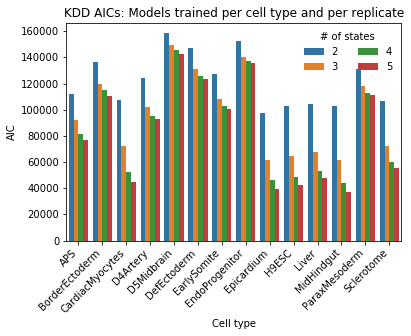

In [26]:
sns.barplot(x='ct', y='aic', hue='n_states', data=tog, ci='sd',
           order=sorted(df['ct'].drop_duplicates()))
plt.xticks(rotation=45, ha='right')
plt.title('KDD AICs: Models trained per cell type and per replicate')
plt.legend(title='# of states', ncol=2, frameon=False)
plt.ylabel('AIC')
plt.xlabel('Cell type')